## Naive Bayes (NB)

Naive bayes algorithm is a probabilistic model used for classification tasks that is based on the Bayes theorem:

<img src = "https://images.squarespace-cdn.com/content/v1/591e58f72994cab66b93f891/1495241596804-61O4OLPITD2YJVNERSY3/bayes-rule-e1350930203949.png">

<b>Assumptions of Naive Bayes</b>: Features are independent with each other

<b>Requirement of feature scaling: No</b>

<b>Is multicollinearity an issue?: Yes</b>

<b>Robust to outliers: No</b>

<b>Advantages of Naive Bayes</b>:
1. Fast training and prediction time
2. Provide direct probabilistic prediction
3. Easy to interpret
4. Less hyperparameter tuning required

<b>Disadvantages of Naive Bayes</b>:
1. Model performs poorly if assumption of feature independence is not satisfied
2. Categories that are not seen during model training will result in prediction error, such that zero probabilities are assigned to unknown classes.

<b>Time complexity of model training: O(n * d * c)</b>

<b>Time complexity of model prediction: O(d*c)</b>

<b>Space complexity of model prediction: O(c)</b>

n - Number of samples

d - Number of features

c - Number of target classes

<b>Methods to handle imbalanced dataset</b>:
1. Resampling techniques (Oversampling/SMOTETomek)

## Types of Naive Bayes model

In scikit-learn, there are 5 different types of Naive Bayes model:

1. <b>Bernoulli NB</b> : Used for discrete features with binary or boolean types
2. <b>Categorical NB</b> : Used for discrete features that are categorically distributed
3. <b>Complement NB</b> : Adaptation to multinomial naive bayes model, especially for <b>imbalanced datasets</b>
- Complement naive bayes calculates the probability of item belonging to all classes, instead of a certain class
4. <b>Gaussian NB</b>: Used for continuous features with assumption of normally distributed
5. <b>Multinomial NB</b>: Used for discrete features with integer counts

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.datasets import load_wine
from dython.nominal import associations
from skopt import BayesSearchCV
from sklearn.naive_bayes import GaussianNB
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from transformers import OutlierCapTransformer, ScalingTransformer, GaussianTransformer

More details related to Exploratory Data Analysis for this classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Classification.ipynb

In [2]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'wine_class'

In [3]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

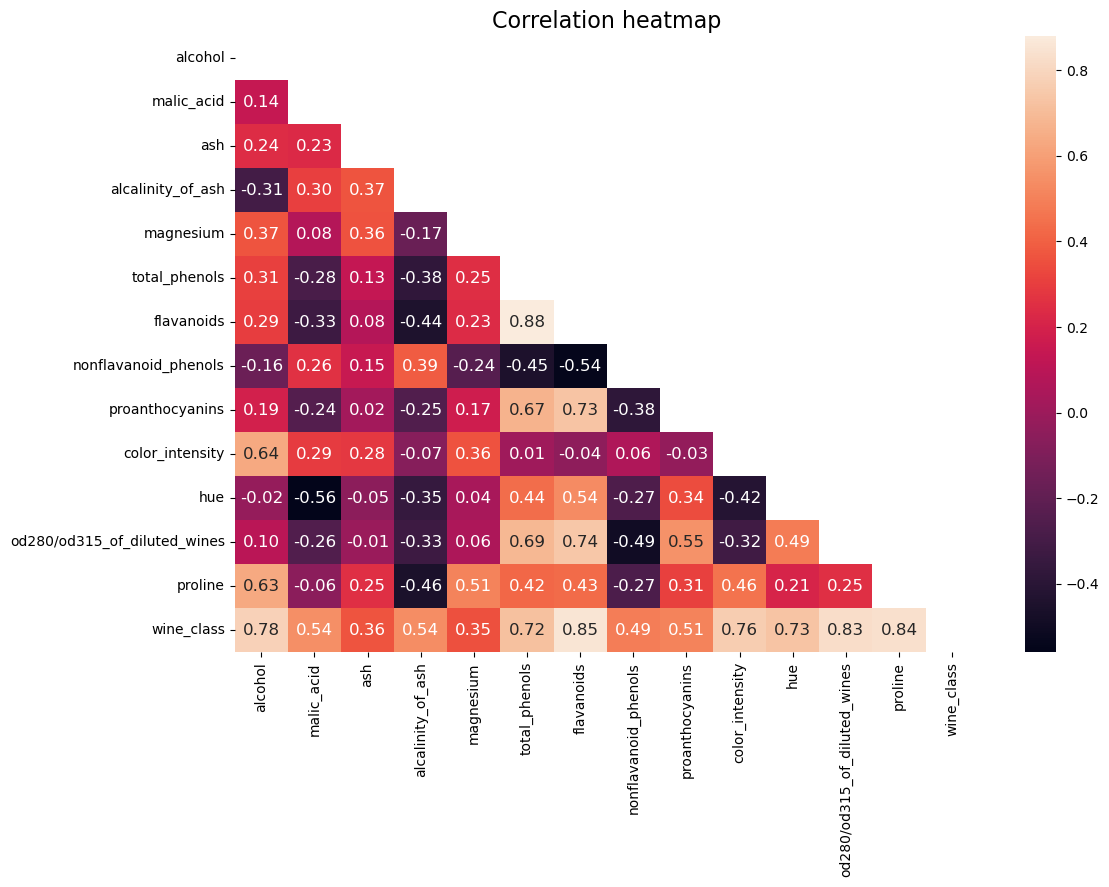

In [4]:
combined_data = pd.concat([X,y],axis=1)
r = associations(combined_data, num_num_assoc='spearman', compute_only=True, nominal_columns = ['wine_class'])
correlation = r['corr']
plt.figure(figsize=(12,8))
sns.heatmap(correlation.astype('float'), annot=True, mask = np.triu(np.ones_like(correlation.astype('float'), dtype=bool)),fmt='.2f',annot_kws={'fontsize':12})
plt.title('Correlation heatmap',size=16)
plt.show()

From the correlation heatmap above, there is a very strong correlation between flavenoids and total_phenols according to spearman correlation method. Either flavenoids and total_phenols variable can be removed from the dataset to avoid multicollinearity problem.

Note that correlation heatmaps only identify bivariate relationships. A better alternative to detect multicollinearity is using Variance Inflation Factor (VIF)

In [5]:
max_vif = np.inf
while max_vif > 5:
    vif = [variance_inflation_factor(X.select_dtypes('float').values, i) for i in range(X.select_dtypes('float').shape[1])]
    max_vif = np.max(vif)
    if max_vif > 5:
        column = pd.DataFrame({'vif': vif}, index=X.select_dtypes('float').columns).idxmax().values[0]
        X.drop([column],axis=1,inplace=True)
        print(column, 'column is removed with vif value of',max_vif)

alcohol column is removed with vif value of 206.1890565710355
ash column is removed with vif value of 163.29344216345316
total_phenols column is removed with vif value of 61.74814049718233
magnesium column is removed with vif value of 51.526969419366225
od280/od315_of_diluted_wines column is removed with vif value of 43.34567295520322
alcalinity_of_ash column is removed with vif value of 32.559609249388096
hue column is removed with vif value of 21.711004203855417
proanthocyanins column is removed with vif value of 14.515914948323369
proline column is removed with vif value of 11.141329391065753
nonflavanoid_phenols column is removed with vif value of 6.758138905693185


In [6]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - Gaussian Naive Bayes (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.8722777425380215
Best hyperparameters for fold 1: OrderedDict([('classification__var_smoothing', 9.475451810136525e-09)])
Test F1 score for fold 1: 1.0



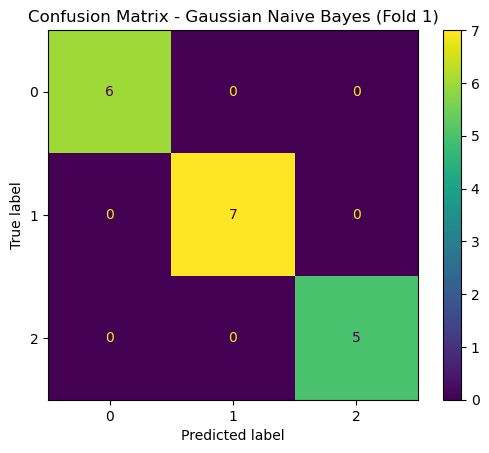


Validation F1 score for fold 2: 0.9027259287947773
Best hyperparameters for fold 2: OrderedDict([('classification__var_smoothing', 2.1143879382110346e-06)])
Test F1 score for fold 2: 0.8461538461538461



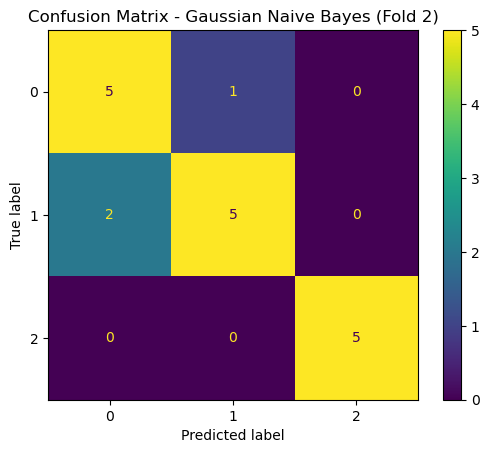


Validation F1 score for fold 3: 0.8624888143618794
Best hyperparameters for fold 3: OrderedDict([('classification__var_smoothing', 7.944066425653581e-07)])
Test F1 score for fold 3: 1.0



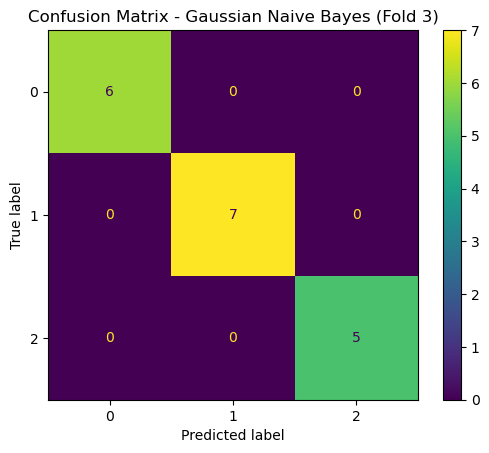


Validation F1 score for fold 4: 0.8566587691624399
Best hyperparameters for fold 4: OrderedDict([('classification__var_smoothing', 0.0028887801613792377)])
Test F1 score for fold 4: 0.9487179487179486



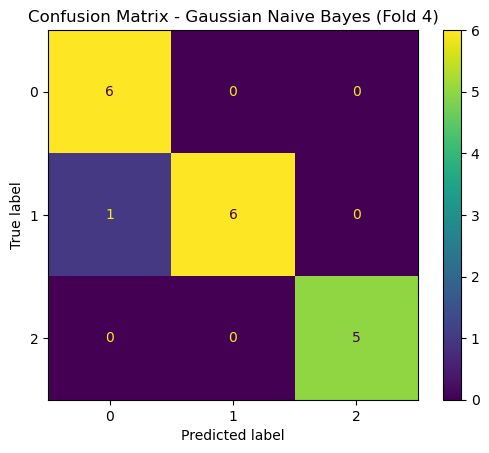


Validation F1 score for fold 5: 0.8637832285345896
Best hyperparameters for fold 5: OrderedDict([('classification__var_smoothing', 5.505588167085756e-05)])
Test F1 score for fold 5: 0.9474747474747475



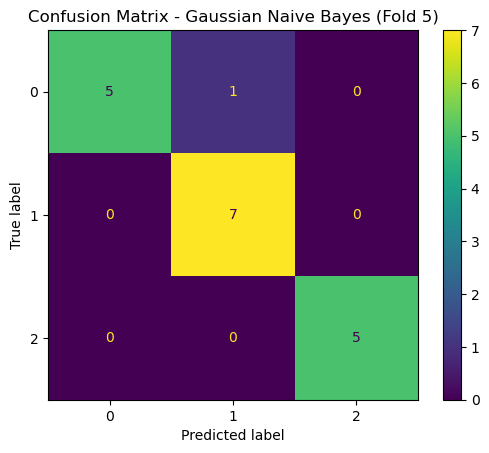


Validation F1 score for fold 6: 0.8929555050706842
Best hyperparameters for fold 6: OrderedDict([('classification__var_smoothing', 0.00021358504876109092)])
Test F1 score for fold 6: 0.9474747474747475



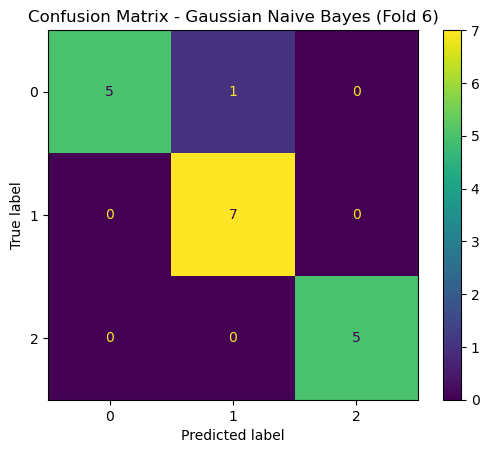


Validation F1 score for fold 7: 0.9093008473008473
Best hyperparameters for fold 7: OrderedDict([('classification__var_smoothing', 3.959338255347476e-07)])
Test F1 score for fold 7: 0.7166666666666668



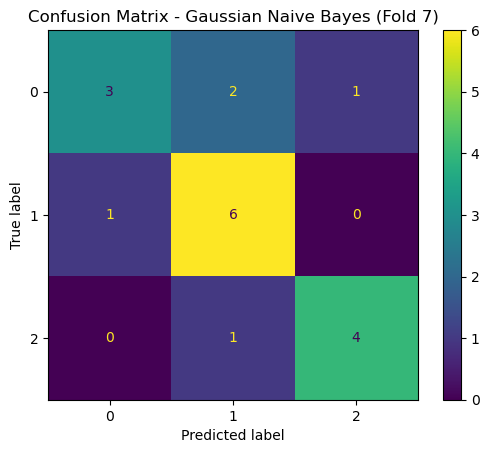


Validation F1 score for fold 8: 0.8639430213798045
Best hyperparameters for fold 8: OrderedDict([('classification__var_smoothing', 0.14426212960026258)])
Test F1 score for fold 8: 0.8424242424242424



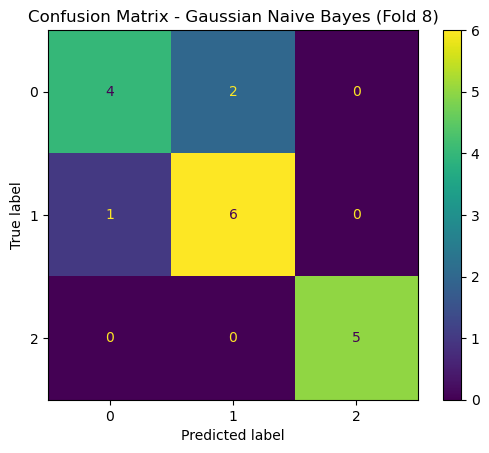


Validation F1 score for fold 9: 0.8944673993839427
Best hyperparameters for fold 9: OrderedDict([('classification__var_smoothing', 0.06592027444433632)])
Test F1 score for fold 9: 0.8968253968253969



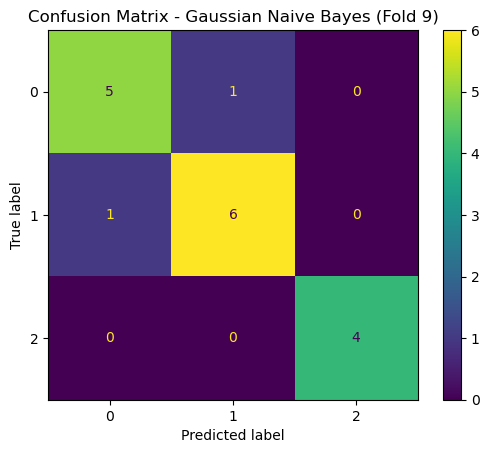


Validation F1 score for fold 10: 0.8833725907162439
Best hyperparameters for fold 10: OrderedDict([('classification__var_smoothing', 0.03565541187538621)])
Test F1 score for fold 10: 0.8296296296296296



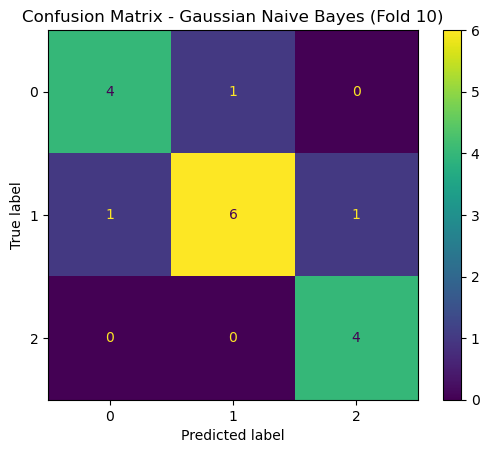


----------------------
Average validation F1 score: 0.8801973847243231
Average test F1 score: 0.8975367225367223


In [7]:
clf = GaussianNB()
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(['gaussian',GaussianTransformer(X.columns.tolist())])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__var_smoothing'] = Real(0.000000001,1,'log-uniform')
nested_cv(X, y, pipeline, search_space)

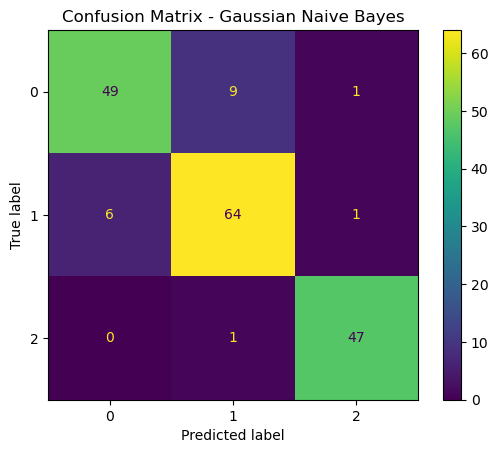

In [8]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - Gaussian Naive Bayes")
plt.grid(False)
plt.show()